# CSV -> NPZ (PID)

## 실험 1
- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상: 목표온도 - 측정온도

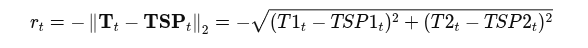

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import os

csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline1_T-Tsp.npz"

all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions=df[['Q1','Q2']].values[:-1]
    rewards = -np.linalg.norm(
        df[['T1','T2']].values[:-1] - df[['TSP1','TSP2']].values[:-1],
        axis=1,
        keepdims=True
    )
    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")


## 실험 2
- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상: 목표온도(t+1) - 측정온도(t+1)

t시점의 Q를 제어할 경우 t시점의 T1,T2에 영향을 끼치는 것이 아닌 t+1시점의 T1,T2가 영향을 끼치게 됨.
그렇기에 다음 시점의 목표온도와 측정온도의 차이를 보상함수로 지정함.

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import os

csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline2_T-Tsp_next.npz"

all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions=df[['Q1','Q2']].values[:-1]
    rewards = -np.linalg.norm(
        df[['T1','T2']].values[1:] - df[['TSP1','TSP2']].values[1:],
        axis=1,
        keepdims=True
    )
    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")


## 실험 3

- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2


앞선 방식들은 올바른 액션을 취해도 현재 상태가 좋지 않으면 보상 또한 좋지 않았다.

즉, 보상이 액션이 아닌 상태에 의존적이었다.

ex) 

Tsp가 60일때

    T가 20일 때 Q를 100으로 하여도 -40의 보상

    T가 50일 때 Q를 100으로 하면 -10의 보상

즉, 둘 다 올바른 행동이었지만 상태에 따라 보상이 달라진다.

- 보상:  PBRS(Potential-Based Reward Shaping) 적용 

-> Φ(t) = -‖T_t - TSP_t‖

-> rt=0 //개선정도만이 보상의 척도가 됨.

-> reward_t = rt + γ * Φ(t+1) - Φ(t) 




현재의 행동으로 인해 다음 상태의 개선정도가 보상으로서 작용된다.

| 상황             | PBRS 보상     | 유도되는 행동  |
|------------------|---------------|----------------|
| 목표에 가까워짐  | 양의 보상 ↑   | 접근           |
| 그대로 유지      | 거의 0        | 정지 유지       |
| 목표에서 멀어짐  | 음의 보상 ↓   | 복귀 시도       |


In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os

csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline3_PBRS.npz"


all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    print(file_path)

    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions = df[['Q1','Q2']].values[:-1]
    
    # PBRS 보상
    gamma = 0.99
    T = df[['T1','T2']].values
    TSP = df[['TSP1','TSP2']].values
    phi = -np.linalg.norm(T - TSP, axis=1, keepdims=True)
    rewards = gamma * phi[1:] - phi[:-1]

    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    print(rewards)
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")


50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
[[0.59556863]
 [0.06463704]
 [0.20414279]
 ...
 [0.10038056]
 [0.15550695]
 [0.01416886]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
[[ 0.76922018]
 [ 0.11779328]
 [-0.4410208 ]
 ...
 [ 0.06400526]
 [ 0.01689866]
 [ 0.08236437]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
[[ 0.24505257]
 [-0.04454454]
 [ 0.03984181]
 ...
 [ 0.14653594]
 [ 0.05805235]
 [ 0.08750143]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
[[0.89652303]
 [0.39404965]
 [0.48258058]
 ...
 [0.06147461]
 [0.09004068]
 [0.03092074]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
[[0.58786234]
 [0.30728233]
 [0.10023702]
 ...
 [0.32768054]
 [0.2596934 ]
 [0.14127559]]
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
[[0.79267365]
 [0.31840967]
 [0.23548622]
 ...
 [0.18168177]
 [0.02151217]
 [0.05523584]

## 실험 4

- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상:  PBRS + 기존보상함수 적용 

-> Φ(t) = -‖T_t - TSP_t‖

-> rt = 목표온도(t+1) - 측정온도(t+1) //개선정도와 더불어 측정온도와 목표온도 사이의 차이를 보상으로 함.

-> reward_t = rt + γ * Φ(t+1) - Φ(t) 

개선정도와 기존 보상의 정규화를 위해 min, max 정규화를 시도함.


In [4]:
import pandas as pd
import numpy as np
from glob import glob
import os

# 경로 설정
csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline4_PBRS_reward_norm.npz"

# 하이퍼파라미터
gamma = 0.99

# 저장 리스트
all_obs, all_next_obs, all_actions, all_rewards, all_terminals = [], [], [], [], []

# 파일 목록
csv_files_1 = sorted(glob(os.path.join(csv_dir, 'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2, "PID_episode_*_data.csv")))
csv_files = csv_files_1 + csv_files_2

print(len(csv_files_1), len(csv_files_2))

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    print(f"📄 {file_path}")

    # 상태, 행동
    obs = df[['T1', 'T2', 'TSP1', 'TSP2']].values[:-1]
    next_obs = df[['T1', 'T2', 'TSP1', 'TSP2']].values[1:]
    actions = df[['Q1', 'Q2']].values[:-1]

    T = df[['T1','T2']].values
    TSP = df[['TSP1','TSP2']].values

    # Φ(t): 상태 품질
    phi = -np.linalg.norm(T - TSP, axis=1, keepdims=True)

    # ① PBRS: 변화량
    pbrs_term = gamma * phi[1:] - phi[:-1]

    # ② 오차 기반 보상: 다음 시점에서의 목표 온도와의 거리
    error_term = -np.linalg.norm(T[1:] - TSP[1:], axis=1, keepdims=True)

    # Min-Max 정규화
    pbrs_norm = (pbrs_term - pbrs_term.min()) / (pbrs_term.max() - pbrs_term.min() + 1e-8)
    error_norm = (error_term - error_term.min()) / (error_term.max() - error_term.min() + 1e-8)

    # 결합 보상
    rewards = pbrs_norm + error_norm

    # terminal
    terminals = np.zeros((len(obs), 1), dtype=np.float32)
    terminals[-1] = 1.0

    # 저장
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

# 저장
dataset = {
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals': np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)

print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")


50 46
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
📄 /home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
📄 /home